# Poisson equation in a multi-patch domain

In [52]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt

np.set_printoptions(linewidth=100000)

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology, adaptive
from pyiga import assemble_cy

In [33]:
# define discretization space (we may choose nested discretization spaces)
p = 3
N = 10
kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),)]

In [34]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(np.pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-np.pi/2).translate((-2, 1))
]

patches = [(kv, g) for kv,g in zip(kvs,geos)]

In [35]:
# source term f and Dirichlet boundary function g
f  = lambda x, y: np.exp(-5 * ((x-0.3)**2 + (y-1)**2))
gD = lambda x, y: 1e-1 * np.sin(8*x)

# Robin boundary data such that \partial_n u + alpha * u = g1, if alpha=0 this represents also a Neumann boundary condition.
gN = lambda x, y: 0.
alpha = lambda x, y: 0.

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
M.set_boundary_id({'Neumann/Robin':{(0,2),(2,3),(3,2),(3,3)},
                   'Dirichlet':{(0,0),(0,3),(1,1),(2,0),(2,2),(3,0)}})

# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("inner(grad(u), grad(v)) * dx", arity = 2)
Fh = MP.assemble_volume("f * v * dx", arity=1, physical=True, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann/Robin')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Neumann/Robin')

setting up constraints took 0.00621342658996582 seconds.
Basis setup took 0.0024611949920654297 seconds


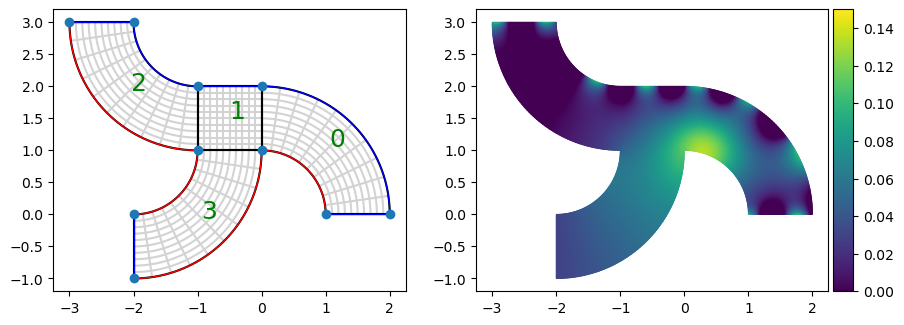

In [36]:
# set up and solve linear system by eliminating Dirichlet DoFs from the system
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

# restrict solution to each individual patch (kvs on every patch) and visualize solution together with the mesh
fig, ax = plt.subplots(1,2,figsize=(10,5))
M.plotmesh(patch_idx = True, knots=True, nodes=True, bcolor={'Dirichlet':'blue','Neumann/Robin':'red'}, axis=ax[0])
MP.plot(u, range = (0, 1.5e-1),cbar=True, cmap='viridis', axis=ax[1], aspect='equal', cbar_width=0.2, cbar_pad = 0.05);
ax[0].axis('scaled'); #ax[1].axis('scaled');

# Computerchip

In [47]:
# define geometry
def ComputerChip(p, N):
    geos = [
        geometry.Quad(np.array([[0,0.5,0.35, 0.5],[0,0,0.3,0.15]])),
        geometry.Quad(np.array([[0, 0.35, 0, 0.17],[0, 0.3, 0.6, 0.6]])),
        geometry.Quad(np.array([[0.35, 0.5, 0.17, 0.5],[0.3, 0.45, 0.6, 0.6]])),
        geometry.Quad(np.array([[0.17, 0.5, 0.17, 0.5],[0.6, 0.6, 0.8, 0.8]])),
        geometry.Quad(np.array([[0.5,1,0.5, 0.65],[0,0,0.15,0.3]])),
        geometry.Quad(np.array([[0.65, 1, 0.83,1],[0.3,0,0.6,0.6]])),
        geometry.Quad(np.array([[0.65, 0.83, 0.5, 0.5],[0.3, 0.6, 0.45, 0.6]])),
        geometry.Quad(np.array([[0.5, 0.83, 0.5, 0.83],[0.6, 0.6, 0.8, 0.8]])),
    ]

    kvs = 8 * [2 * (bspline.make_knots(p, 0.0, 1.0, N),)]
    
    patches = [(kv, g) for kv,g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    
    M.set_boundary_id({'Dirichlet':{(0,1),(2,0),(4,1),(6,2)},
                   'Neumann':{(1,1),(1,2),(3,1),(3,2),(5,1),(5,3),(7,1),(7,3)},
                   'Robin' : {(0,0),(4,0)}})
    M.set_domain_id({0:{0,1,2,4,5,6}, 1:{3,7}})
    return M

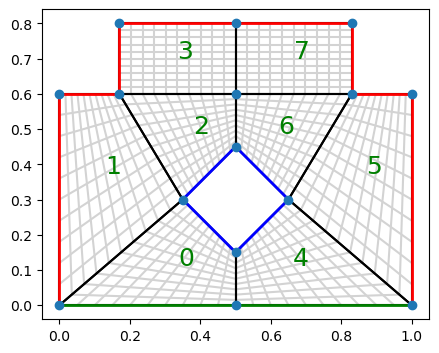

In [48]:
M = ComputerChip(3,10)

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
M.plotmesh(patch_idx = True, knots=True, nodes=True, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)
plt.axis('scaled');

In [40]:
kappa = 130.0
alpha = 0.2
f = lambda x,y: 0.0
gN = lambda x,y: 0.0
gD = lambda x,y: 500.0
gR = lambda x,y: 300.0*alpha
lambda0 = 0.01
lambda1 = 3.95

In [41]:
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("lambda0 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=0, lambda0=lambda0) + MP.assemble_volume("lambda1 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=1, lambda1=lambda1)
Fh = MP.assemble_volume("f * v * dx", arity=1, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Robin')
Nh += MP.assemble_surface('(gR * v) * ds', arity=1, gR=gR, boundary_idx='Robin')

setting up constraints took 0.03556513786315918 seconds.
Basis setup took 0.006765604019165039 seconds


In [42]:
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

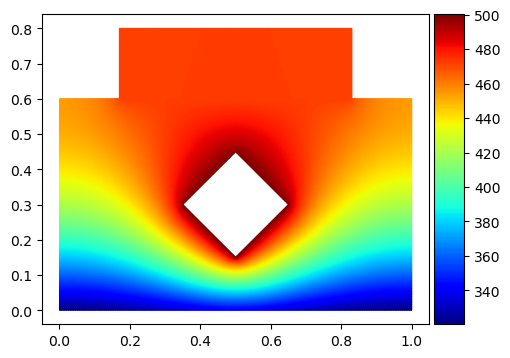

In [44]:
MP.plot(u, cbar=True, cmap='jet', aspect='equal', figsize=(5,5), physical=True);

# Using non-matching multi-patch domains for adaptive refinement

In [49]:
def solveChip(MP):
    Kh = MP.assemble_volume("lambda0 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=0, lambda0=lambda0) + MP.assemble_volume("lambda1 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=1, lambda1=lambda1)
    Fh = MP.assemble_volume("f * v * dx", arity=1, f=f) #f is living in the physical domain

    Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann')
    Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Robin')
    Nh += MP.assemble_surface('(gR * v) * ds', arity=1, gR=gR, boundary_idx='Robin')

    LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
    return LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

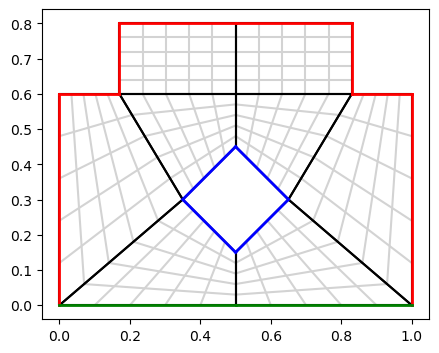

setting up constraints took 0.012340784072875977 seconds.
Basis setup took 0.002446413040161133 seconds
Residual contributions took 0.0512 seconds.
Jump contributions took 0.0537 seconds.


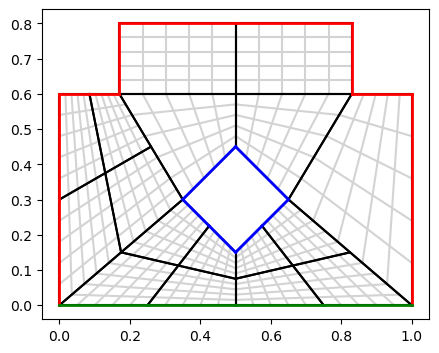

2 (KnotVector(array([0. , 0. , 0. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1. , 1. , 1. ]), 3),) 16 (KnotVector(array([0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. , 1. ]), 3),)
interface coupling not possible
setting up constraints took 0.03448843955993652 seconds.
Basis setup took 0.002262592315673828 seconds
Residual contributions took 0.103 seconds.
Jump contributions took 0.127 seconds.


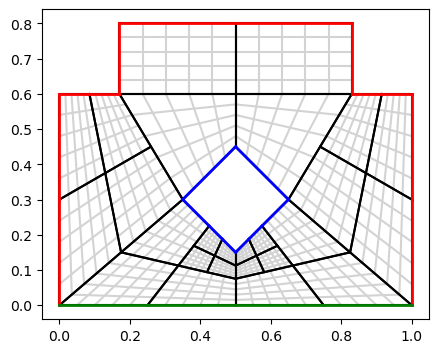

11 (KnotVector(array([0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. , 1. ]), 3),) 20 (KnotVector(array([0.75, 0.75, 0.75, 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.  , 1.  , 1.  ]), 3),)
interface coupling not possible
6 (KnotVector(array([0. , 0. , 0. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1. , 1. , 1. ]), 3),) 24 (KnotVector(array([0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. , 1. ]), 3),)
interface coupling not possible
10 (KnotVector(array([0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. , 1. ]), 3),) 19 (KnotVector(array([0.75, 0.75, 0.75, 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.  , 1.  , 1.  ]), 3),)
interface coupling not possible
12 (KnotVector(array([0.5, 0.5, 0.5, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1. , 1. , 1. ]), 3),) 21 (KnotVector(array([0.75, 0.75, 0.75, 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.  , 1.  , 1.  ]), 3),)
interface coupling not possible
2 (KnotVector(array([0. , 0. , 0. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1. , 1. , 1. ]), 3),) 16 (KnotVector(array([0.5, 0.5, 0.5, 

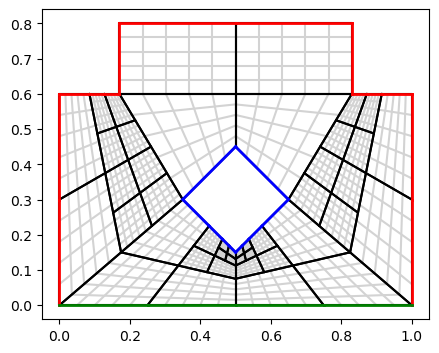

24 (KnotVector(array([0.5 , 0.5 , 0.5 , 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.75, 0.75, 0.75]), 3),) 6 (KnotVector(array([0. , 0. , 0. , 0. , 0.2, 0.4, 0.6, 0.8, 1. , 1. , 1. , 1. ]), 3),)
interface coupling not possible


ValueError: negative axis 1 index: -3

In [59]:
M = ComputerChip(3,5)

kappa = 130.0
alpha = 0.2
f = lambda x,y: 0.0
gN = lambda x,y: 0.0
gD = lambda x,y: 500.0
gR = lambda x,y: 300.0*alpha
lambda0 = 0.01
lambda1 = 3.95

maxiter=5
for it in range(maxiter):
    M.plotmesh(patch_idx = False, knots=True, nodes=False, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)
    plt.axis('scaled');
    plt.show()

    MP = assemble.Multipatch(M, automatch=True)
    dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

    #assemble and solve
    u = solveChip(MP)

    #estimate
    err_ind = adaptive.mp_resPois(MP,u,a={0:lambda0, 1:lambda1}, f={0:f, 1:f})

    #mark
    marked_patches = adaptive.quick_mark(err_ind, theta=0.8)

    #refine
    M.h_refine(patches=marked_patches,ref="rs");